In [1]:
%load_ext lab_black

# Vulnerability

Where do people and energy assets live?

In [2]:
import cartopy.crs as ccrs
from cartopy.feature import STATES, COASTLINE, ShapelyFeature
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import pandas as pd
import regionmask
import seaborn as sns
import xarray as xr

from codebase.fig import figname

Read in the generators data

In [3]:
generators = pd.read_excel(
    "../data/raw/eia/gnovember_generator2020.xlsx",
    skiprows=2,
    sheet_name="Operating",
    index_col="Entity ID",
)
generators.head(5)

,Entity Name,Plant ID,Plant Name,Sector,Plant State,Generator ID,Unit Code,Nameplate Capacity (MW),Net Summer Capacity (MW),Net Winter Capacity (MW),...,Planned Derate of Summer Capacity (MW),Planned Uprate Year,Planned Uprate Month,Planned Uprate of Summer Capacity (MW),County,Latitude,Longitude,Google Map,Bing Map,Balancing Authority Code
Entity ID,,,,,,,,,,,,,,,,,,,,,
63560,"TDX Sand Point Generating, LLC",1.0,Sand Point,IPP Non-CHP,AK,1,NaN,0.9,0.4,0.4,...,,,,,Aleutians East,55.339722,-160.4972,Map,Map,NaN
63560,"TDX Sand Point Generating, LLC",1.0,Sand Point,IPP Non-CHP,AK,2,NaN,0.9,0.3,0.3,...,,,,,Aleutians East,55.339722,-160.4972,Map,Map,NaN
63560,"TDX Sand Point Generating, LLC",1.0,Sand Point,IPP Non-CHP,AK,3,NaN,0.5,0.3,0.3,...,,,,,Aleutians East,55.339722,-160.4972,Map,Map,NaN
63560,"TDX Sand Point Generating, LLC",1.0,Sand Point,IPP Non-CHP,AK,5,NaN,0.7,0.4,0.3,...,,,,,Aleutians East,55.339722,-160.4972,Map,Map,NaN
63560,"TDX Sand Point Generating, LLC",1.0,Sand Point,IPP Non-CHP,AK,WT1,NaN,0.5,0.1,0.1,...,,,,,Aleutians East,55.339722,-160.4972,Map,Map,NaN


Let's keep only TX generators, and let's add some other information

In [4]:
tx_generators = (
    generators.loc[
        lambda df: df["Plant State"] == "TX",
        ["Net Winter Capacity (MW)", "Technology", "Latitude", "Longitude"],
    ]
    .assign(
        **{
            "Net Winter Capacity (MW)": lambda df: pd.to_numeric(
                df["Net Winter Capacity (MW)"]
            )
        }
    )
    .loc[lambda df: df["Net Winter Capacity (MW)"] > 25]
    .dropna()
)

There are too many technologies.
Let's combine them

In [5]:
TECH_KEYS = {
    "Natural Gas Fired Combustion Turbine": "Natural Gas",
    "Conventional Steam Coal": "Other Thermal",
    "Natural Gas Fired Combined Cycle": "Natural Gas",
    "Natural Gas Steam Turbine": "Natural Gas",
    "Conventional Hydroelectric": "Other",
    "Nuclear": "Nuclear",
    "Other Gases": "Natural Gas",
    "Wood/Wood Waste Biomass": "Other Thermal",
    "All Other": "Other",
    "Petroleum Coke": "Other Thermal",
    "Onshore Wind Turbine": "Wind",
    "Batteries": "Other",
    "Solar Photovoltaic": "Solar",
    "Natural Gas Internal Combustion Engine": "Natural Gas",
    "Petroleum Liquids": "Other Thermal",
    "Landfill Gas": "Other Thermal",
    "Other Waste Biomass": "Other Thermal",
    "Flywheels": "Other",
}
tx_generators["Technology"] = tx_generators["Technology"].replace(TECH_KEYS)
tx_generators = tx_generators.loc[
    lambda df: df["Technology"].isin(
        ["Natural Gas", "Other Thermal", "Nuclear", "Wind", "Solar"]
    )
]

Now add in the population data

In [6]:
Xi, Xf = (-107, -92.5)
Yi, Yf = (25.5, 37)

In [7]:
pop = (
    xr.open_dataarray("../data/raw/gpwv4/gpw_v4_population_density_rev11_2pt5_min.nc")
    .sel(raster=5, longitude=slice(Xi, Xf), latitude=slice(Yf, Yi))
    .rename({"longitude": "lon", "latitude": "lat"})
)

Keep only population data from TX

In [8]:
states = regionmask.defined_regions.natural_earth.us_states_50
mask = states.mask(pop)
tx_idx = states.map_keys("Texas")
pop_tx = pop.where(mask == tx_idx)

Now get the grid data

In [9]:
grid_feature = ShapelyFeature(
    shpreader.Reader("../data/raw/interconnects/TexasInterconnect.shp").geometries(),
    ccrs.PlateCarree(),
    edgecolor="gray",
    facecolor="none",
)

Create data projections

In [10]:
map_proj = ccrs.PlateCarree()
data_proj = ccrs.PlateCarree()

Create the map

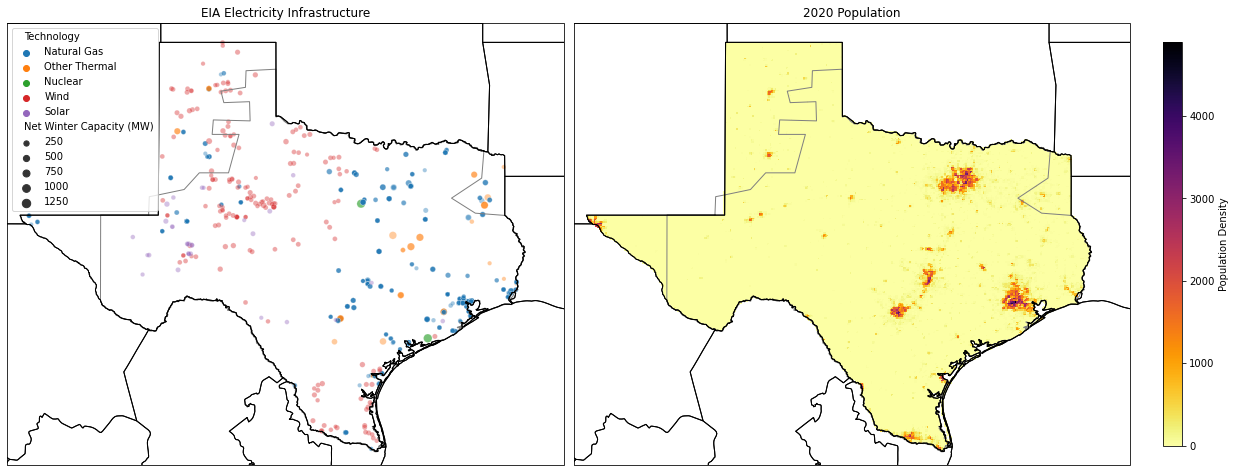

In [11]:
fig, axes = plt.subplots(
    nrows=1, ncols=2, subplot_kw=dict(projection=map_proj), figsize=(18, 8)
)
ax = axes[0]
scp = sns.scatterplot(
    x="Longitude",
    y="Latitude",
    size="Net Winter Capacity (MW)",
    hue="Technology",
    data=tx_generators,
    transform=data_proj,
    ax=ax,
    alpha=0.4,
)
ax.set_title("EIA Electricity Infrastructure")

ax = axes[1]
C0 = pop_tx.plot(ax=ax, transform=data_proj, add_colorbar=False, cmap="inferno_r")
ax.set_title("2020 Population")

for ax in axes.flat:
    ax.add_feature(grid_feature, label="ERCOT")
    ax.add_feature(STATES)
    ax.add_feature(COASTLINE)
    ax.set_extent([Xi, Xf, Yi, Yf], crs=ccrs.PlateCarree())

fig.canvas.draw()
fig.tight_layout()
fig.subplots_adjust(right=0.875)
cax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(C0, cax=cax, label="Population Density")

plt.savefig(figname("vulnerability.jpg"), dpi=500)
plt.show()